In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps

# stel de logger in om alleen foutmeldingen naar het scherm te printen
ps.set_log_level("ERROR")

# print de versies van belangrijke Python packages voor pastas
# ps.show_versions(numba=True)

%config InlineBackend.figure_format = 'retina'

/Applications/anaconda3/envs/mude/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (

# Preprocessing

For time series analysis, groundwater levels and explanatory series are needed. Both come in different lengths, frequencies, and qualities. In many cases, preprocessing of the series is necessary. This notebook illustrates which operations can be performed and when they are needed. The following examples are covered:

**Table of Contents**

- [Cleaning groundwater level series](#cleaning-groundwater-level-series)
- [Simplifying groundwater level series](#simplifying-groundwater-level-series)
- [Making explanatory series equidistant](#making-explanatory-series-equidistant)
- [History of explanatory series](#history-of-explanatory-series)
- [Aligning units](#aligning-units)

## Cleaning groundwater level series

The goal of time series analysis is to explain a groundwater level or head series using input series. Through automatic optimization, the software tries to approximate the series as closely as possible. When there are errors in the series, this can have major consequences for the quality of the model. 

The example below shows a model that was optimized without removing a clear outlier.


Columns (2,3,4,5,6,7,8,13,15,16,18,19,20,21,22,23,25,26,28,30,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.

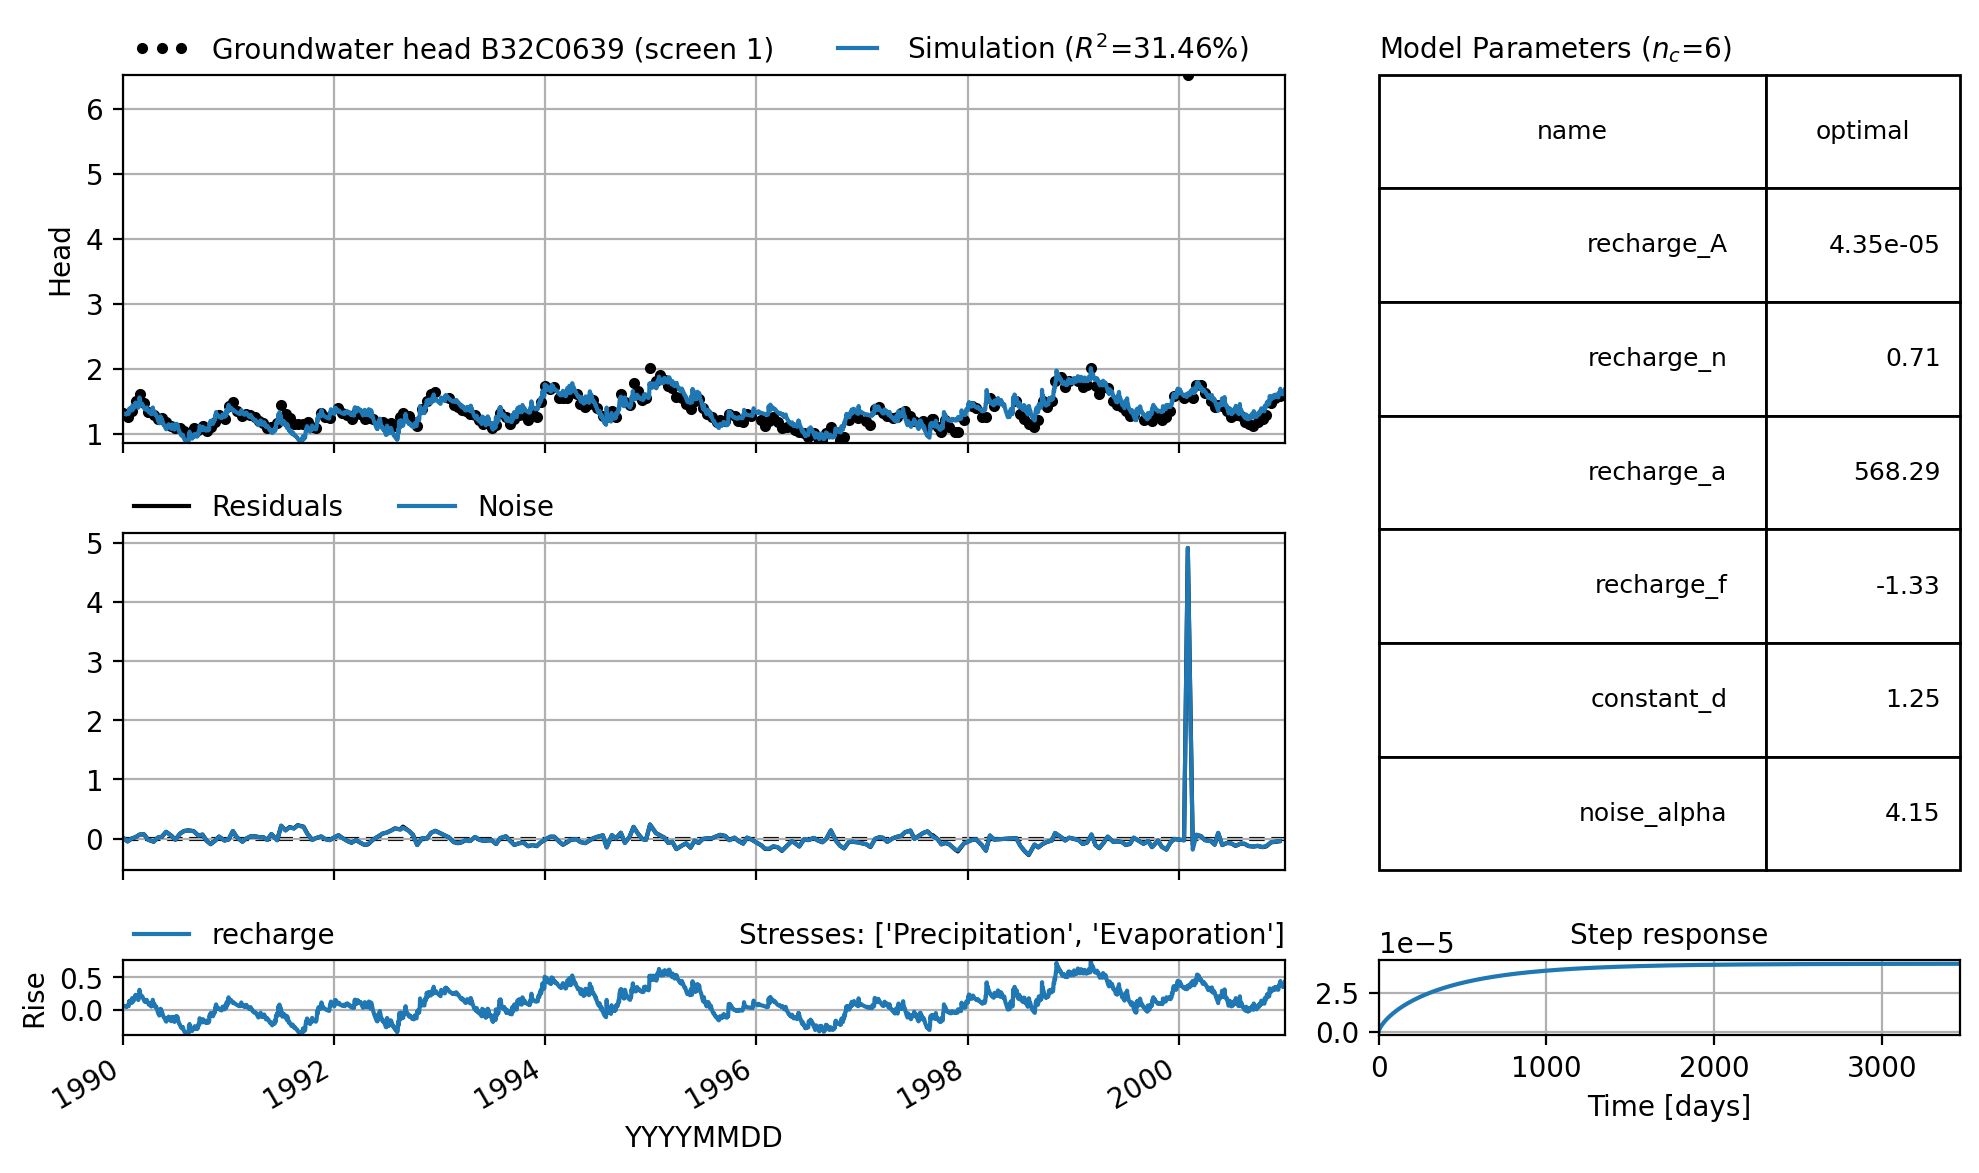

In [2]:
# Read data


raw = pd.read_csv('../model_structure/data/etmgeg_260.txt', skiprows=47, index_col=1, parse_dates=True)


rain = pd.to_numeric(raw['   RH'], errors='coerce') *1e3
evap = pd.to_numeric(raw[' EV24'], errors='coerce') *1e3

rain.name = "Precipitation"
evap.name = "Evaporation"
head = pd.read_csv("data/B32C0639001_changed.csv", index_col=0, parse_dates=True).iloc[:, 0]

head.name = "Groundwater head B32C0639 (screen 1)"


# Create the basic Pastas model
ml = ps.Model(head, name="lineair")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma(), name="recharge")
ml.add_stressmodel(rm)
ml.add_noisemodel(ps.ArNoiseModel())

# Solve the model
tmin = "1990"
tmax = "2001"

ml.solve(tmin=tmin, tmax=tmax, report=False)
ml.plots.results(figsize=(10, 6), adjust_height=True)
plt.tight_layout()

The results of this model are not very encouraging. The explained variance is only 31%. This is partly due to the large deviation caused by the outlier, but also the standard errors of the parameters are relatively large, and the response time to precipitation and evaporation seems rather high by Dutch standards.

We will now look at the results after removing the outlier.

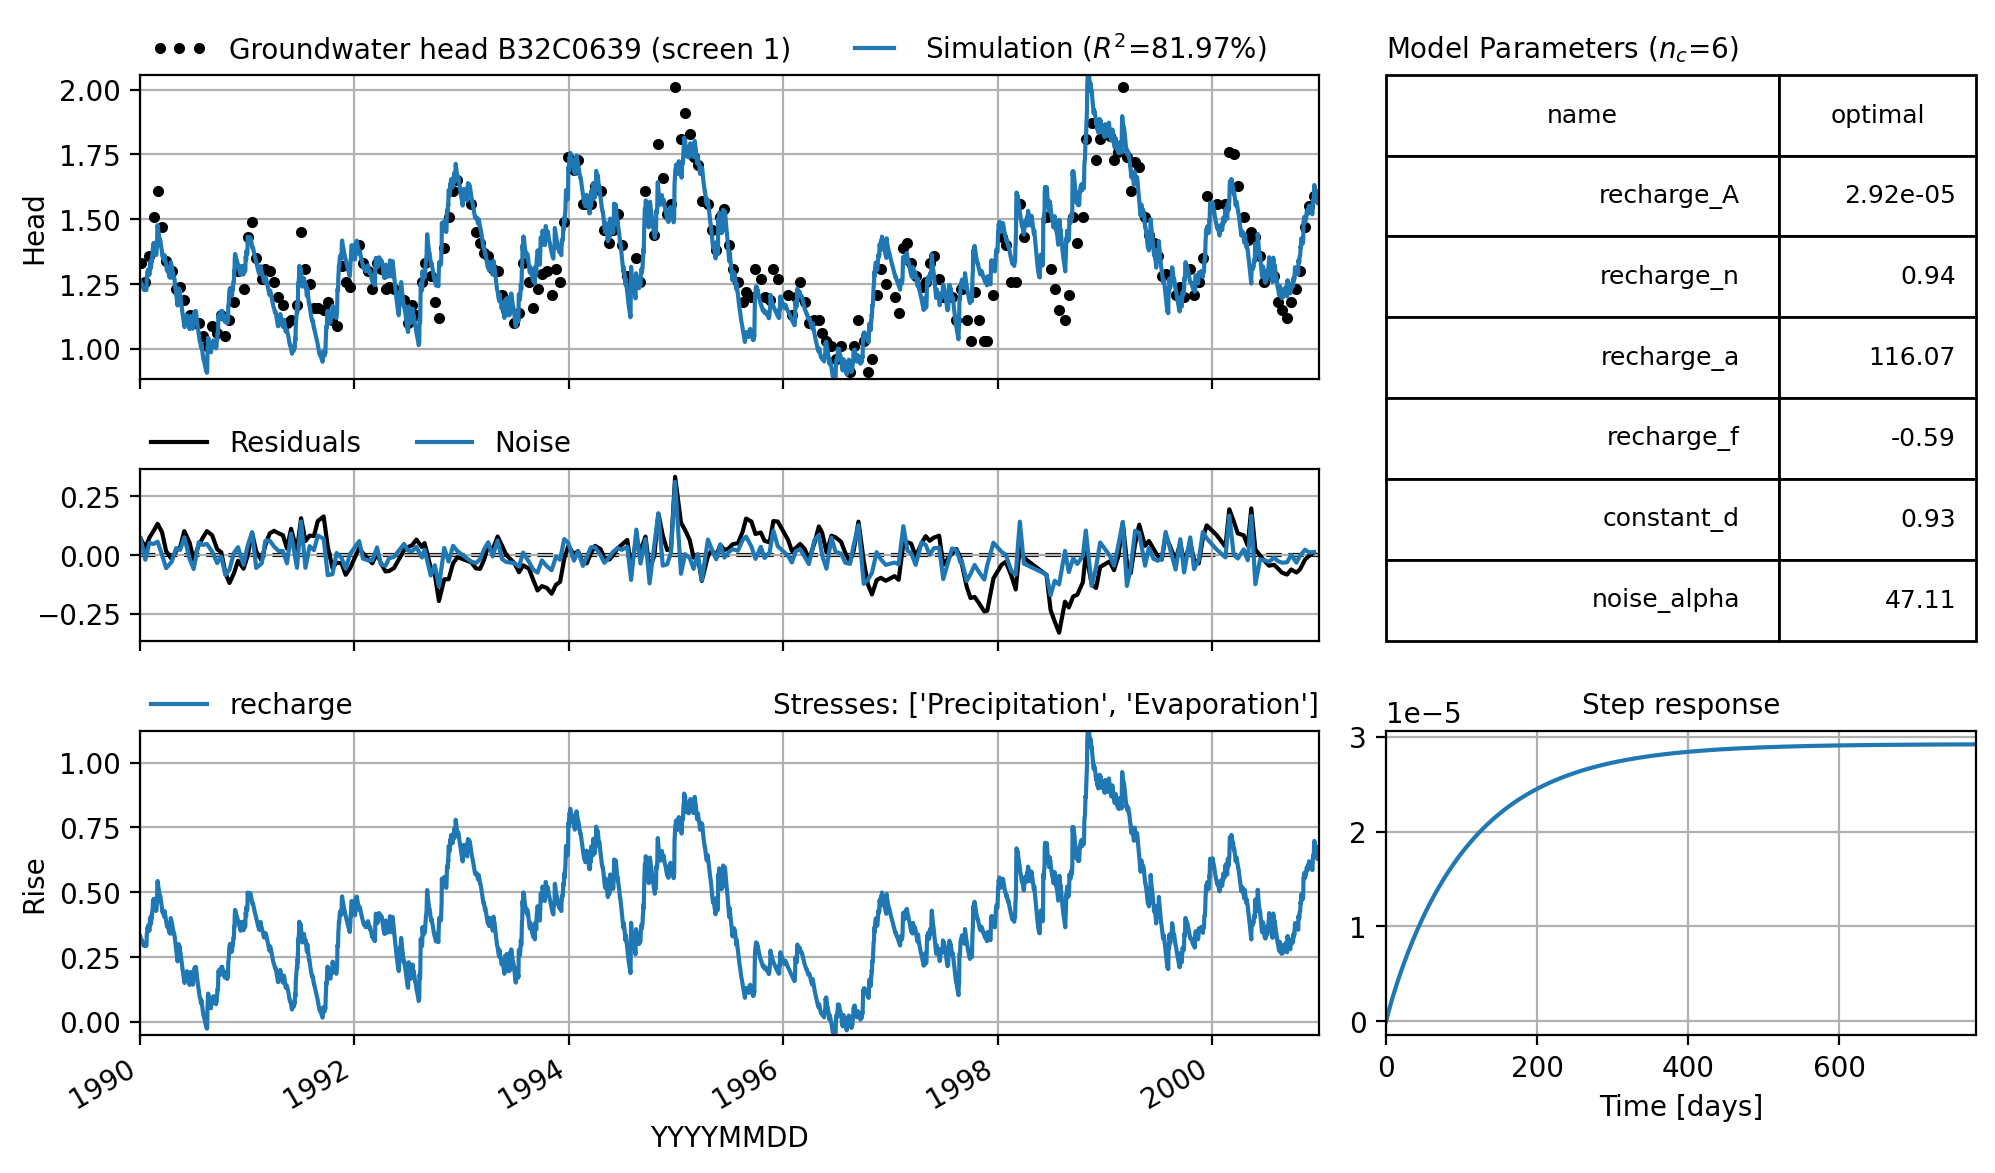

In [3]:
# remove outlier
head.loc[head > 4] = np.nan

# Create the basic Pastas model
ml = ps.Model(head, name="lineair")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma(), name="recharge")
ml.add_stressmodel(rm)
ml.add_noisemodel(ps.ArNoiseModel())

# Solve the model
tmin = "1990"
tmax = "2001"

ml.solve(tmin=tmin, tmax=tmax, report=False)
ml.plots.results(figsize=(10, 6), adjust_height=True)
plt.tight_layout()

The figure above shows that the model performs much better with the cleaned series. It turns out that the outlier (even if there's only one) has a significant impact on the results. In addition to a better fit (82%), the standard errors are also smaller, and the response time has shortened.

## Simplifying groundwater level series

Some series contain very high-frequency data, with, for example, a time step of one day or even shorter. Depending on the goal of the time series analysis and the available input, it may be desirable to aggregate or thin out the series. 

The first example concerns a common situation: for a long time, measurements were taken approximately every two weeks, and in recent years at a high frequency. When using all measurements, the optimization may end up focusing on the high-frequency period, simply because there are more data points. This is the case in the example below.

Columns (2,3,4,5,6,7,8,13,15,16,18,19,20,21,22,23,25,26,28,30,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

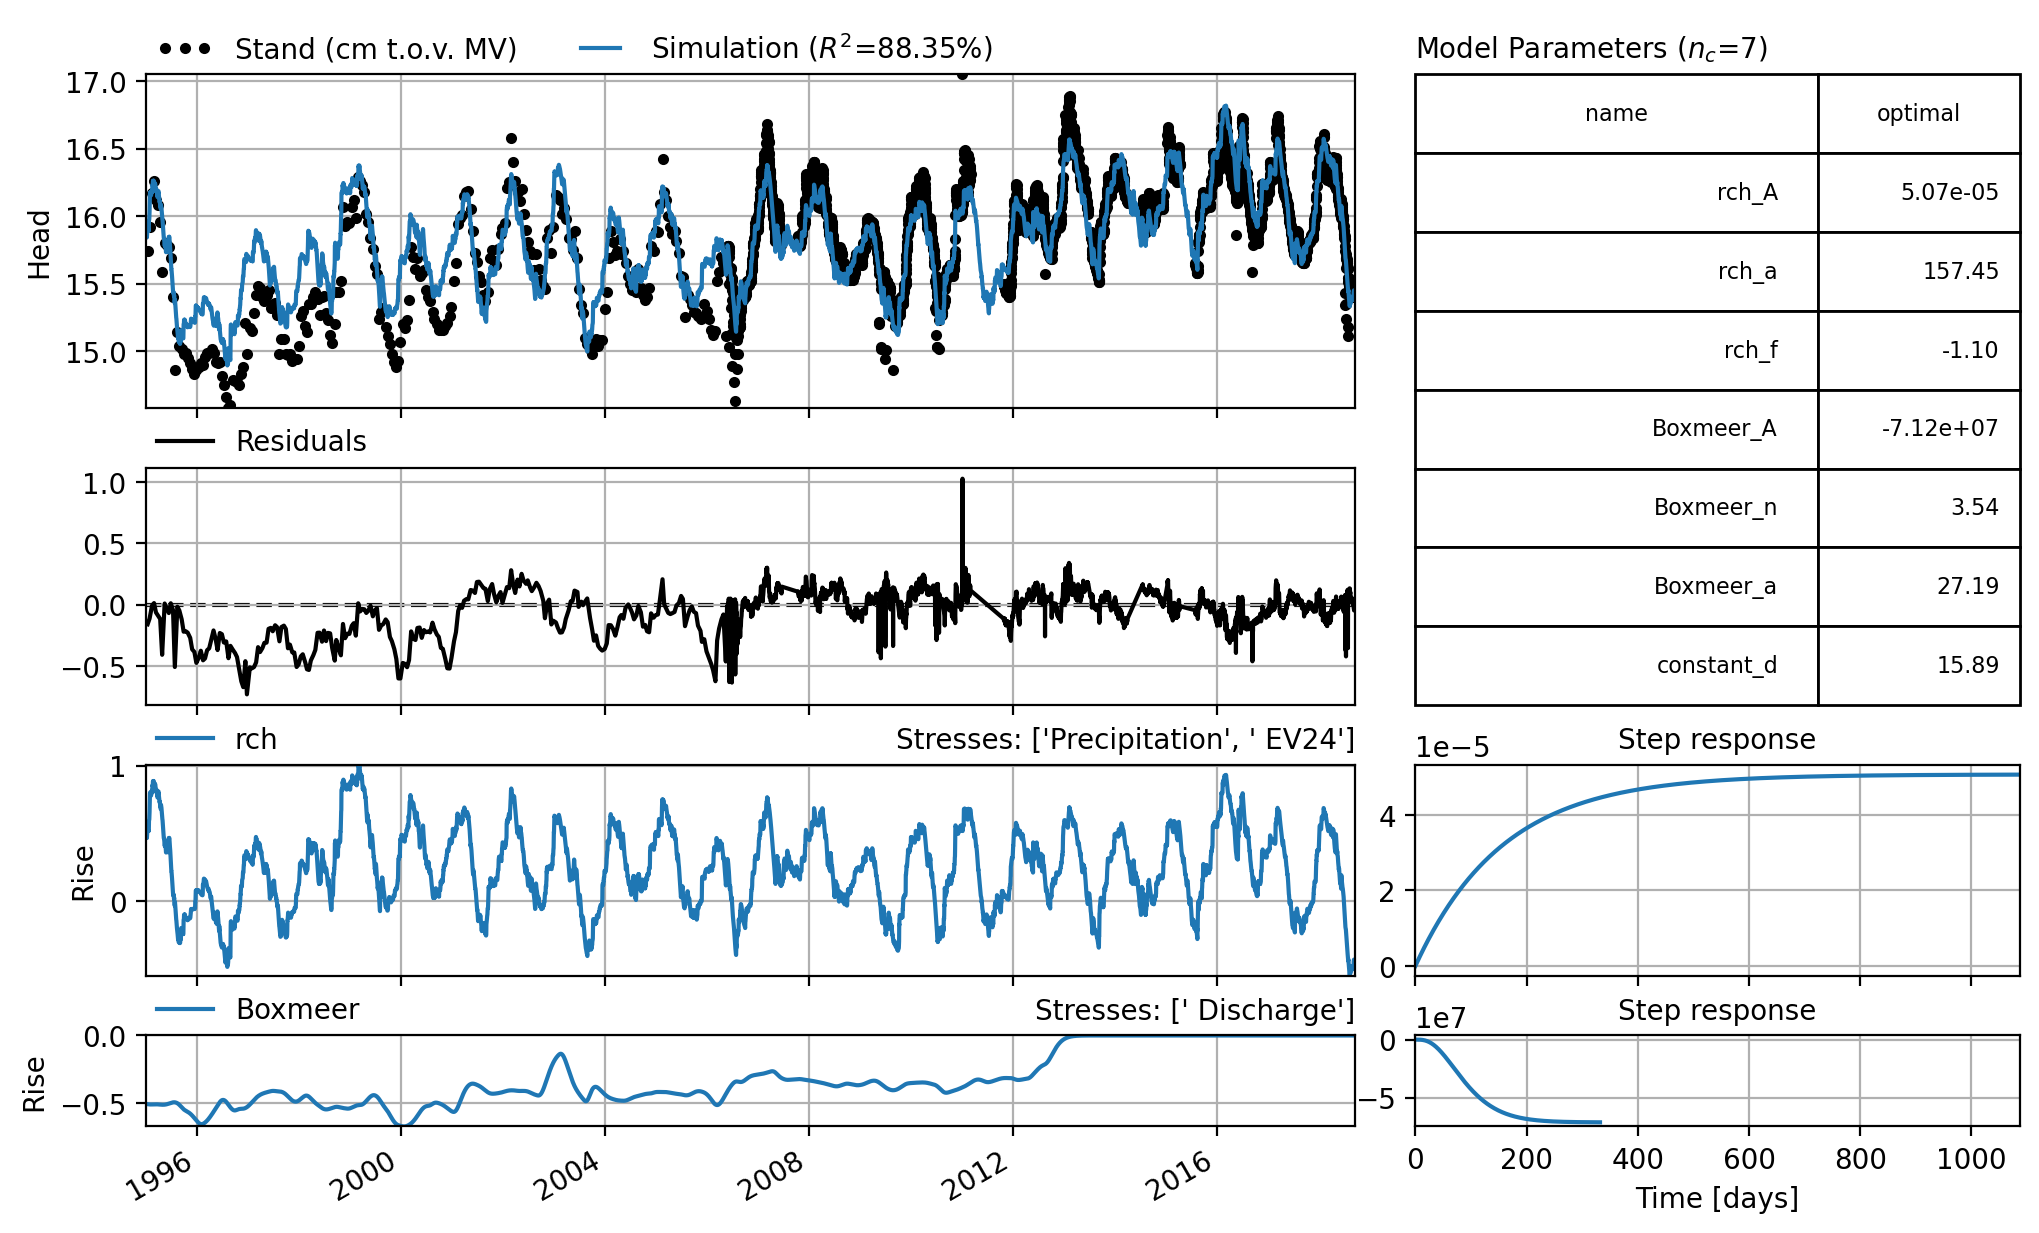

In [4]:
# voorbeeld waar tweewekelijks beter is dan daily
prec = (
    pd.read_csv("../model_structure/data/precipitation_st_anthonis.txt", skiprows=23)
    .assign(YYYYMMDD=lambda df: pd.to_datetime(df["YYYYMMDD"], format="%Y%m%d"))
    .set_index("YYYYMMDD")["   RD"].pipe(pd.to_numeric, errors='coerce')*1e3
)
prec.name = "Precipitation"
prec = prec.asfreq("D").fillna(0.0)

raw = pd.read_csv('../model_structure/data/etmgeg_260.txt', skiprows=47, index_col=1, parse_dates=True)
evap = pd.to_numeric(raw[' EV24'], errors='coerce') *1e3
evap = evap.asfreq("D").fillna(0.0)

head = pd.read_csv('data/B46D0731001_1.csv', skiprows=17, index_col=2, parse_dates=True).iloc[:, 4].astype(float)/100

gwa_vb = pd.read_csv("../model_structure/data/abstraction_vierlingsbeek_daily.csv", index_col="Date",
                   parse_dates=True).iloc[:, 0] / 1e6

ml = ps.Model(head, name="B46D0731 (Screen 1)")
sm1 = ps.RechargeModel(prec, evap, rfunc=ps.Exponential(), name="rch")
sm2 = ps.StressModel(gwa_vb / 1e6, rfunc=ps.Gamma(),
                     name="Boxmeer", up=False, settings="well")
ml.add_stressmodel([sm1, sm2])
#ml.set_parameter("rch_kv", vary=True)
ml.solve(tmin="1995", freq='D', report=False)
ml.plots.results(adjust_height=True, figsize=(10, 6));

Especially at the beginning of the series, the simulated values are consistently higher than the measurements, while in the second half of the series, the simulation generally aligns better. The example below uses the same input, but now the groundwater level series has been resampled so that there are biweekly measurements throughout the entire period.

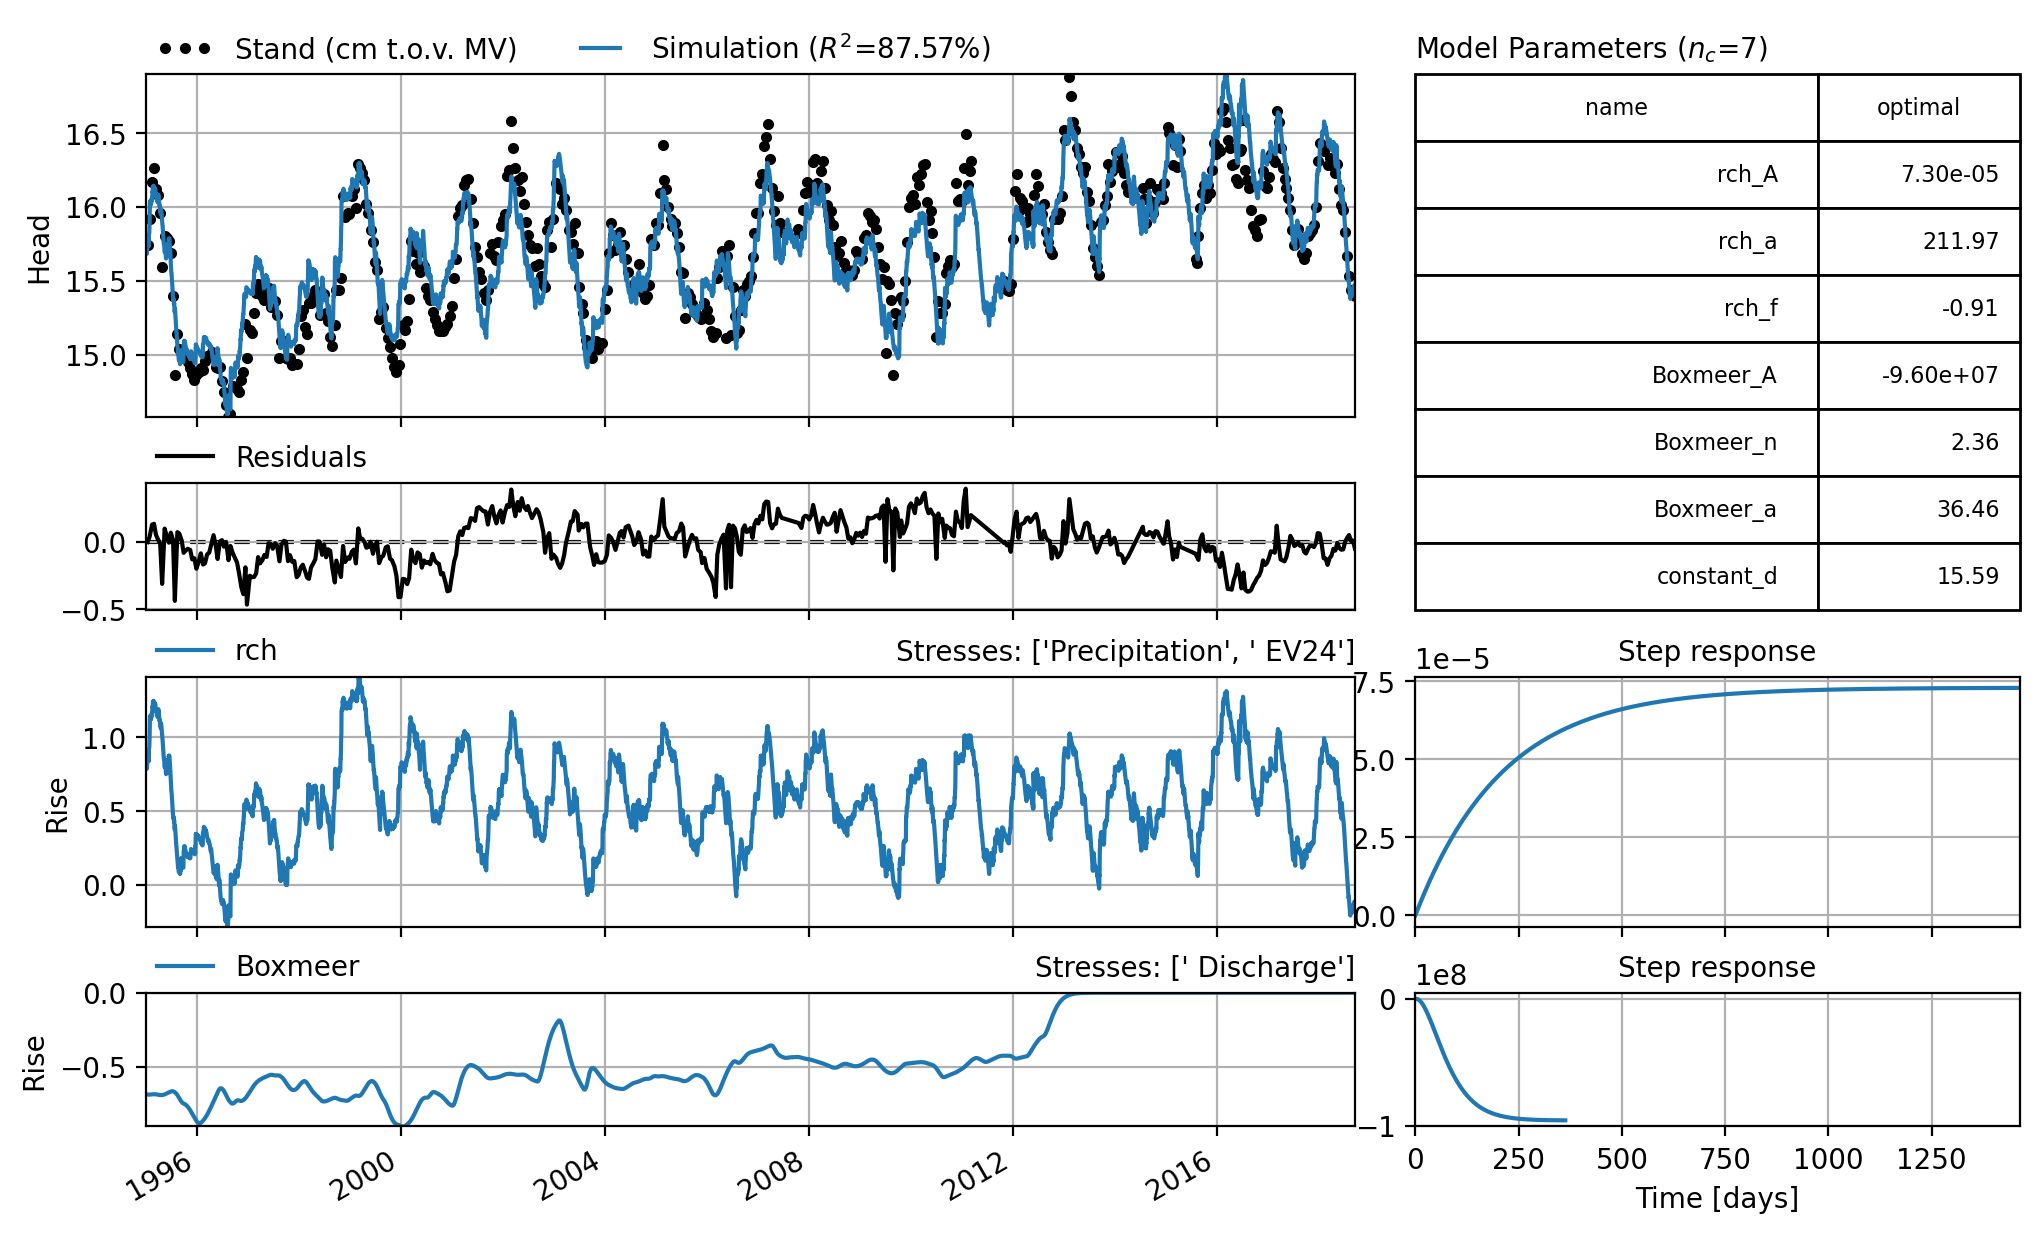

In [5]:
index = ps.timeseries_utils.get_sample(head.index, head.asfreq('14d').index)
head14D = head[index]

ml14D = ps.Model(head14D, name="B46D0731 (Filter 1)")
sm1 = ps.RechargeModel(prec, evap, rfunc=ps.Exponential(), name="rch")
sm2 = ps.StressModel(gwa_vb / 1e6, rfunc=ps.Gamma(),
                     name="Boxmeer", up=False, settings="well")
ml14D.add_stressmodel([sm1, sm2])
ml14D.solve(tmin="1995", freq='D', report=False)
ml14D.plots.results(figsize=(10, 6));

After filtering the high-frequency data, it can be seen that the residuals are now more evenly distributed across the series. The fit in the initial period has improved at the expense of the fit at the end. This has also resulted in a different model; the responses of the contributions have also changed.

There are also situations where it is important to maintain a high frequency. The following example illustrates this. It concerns a monitoring well that is influenced by the tide. In the figure below, it is clearly visible that the groundwater level is affected by the tide.

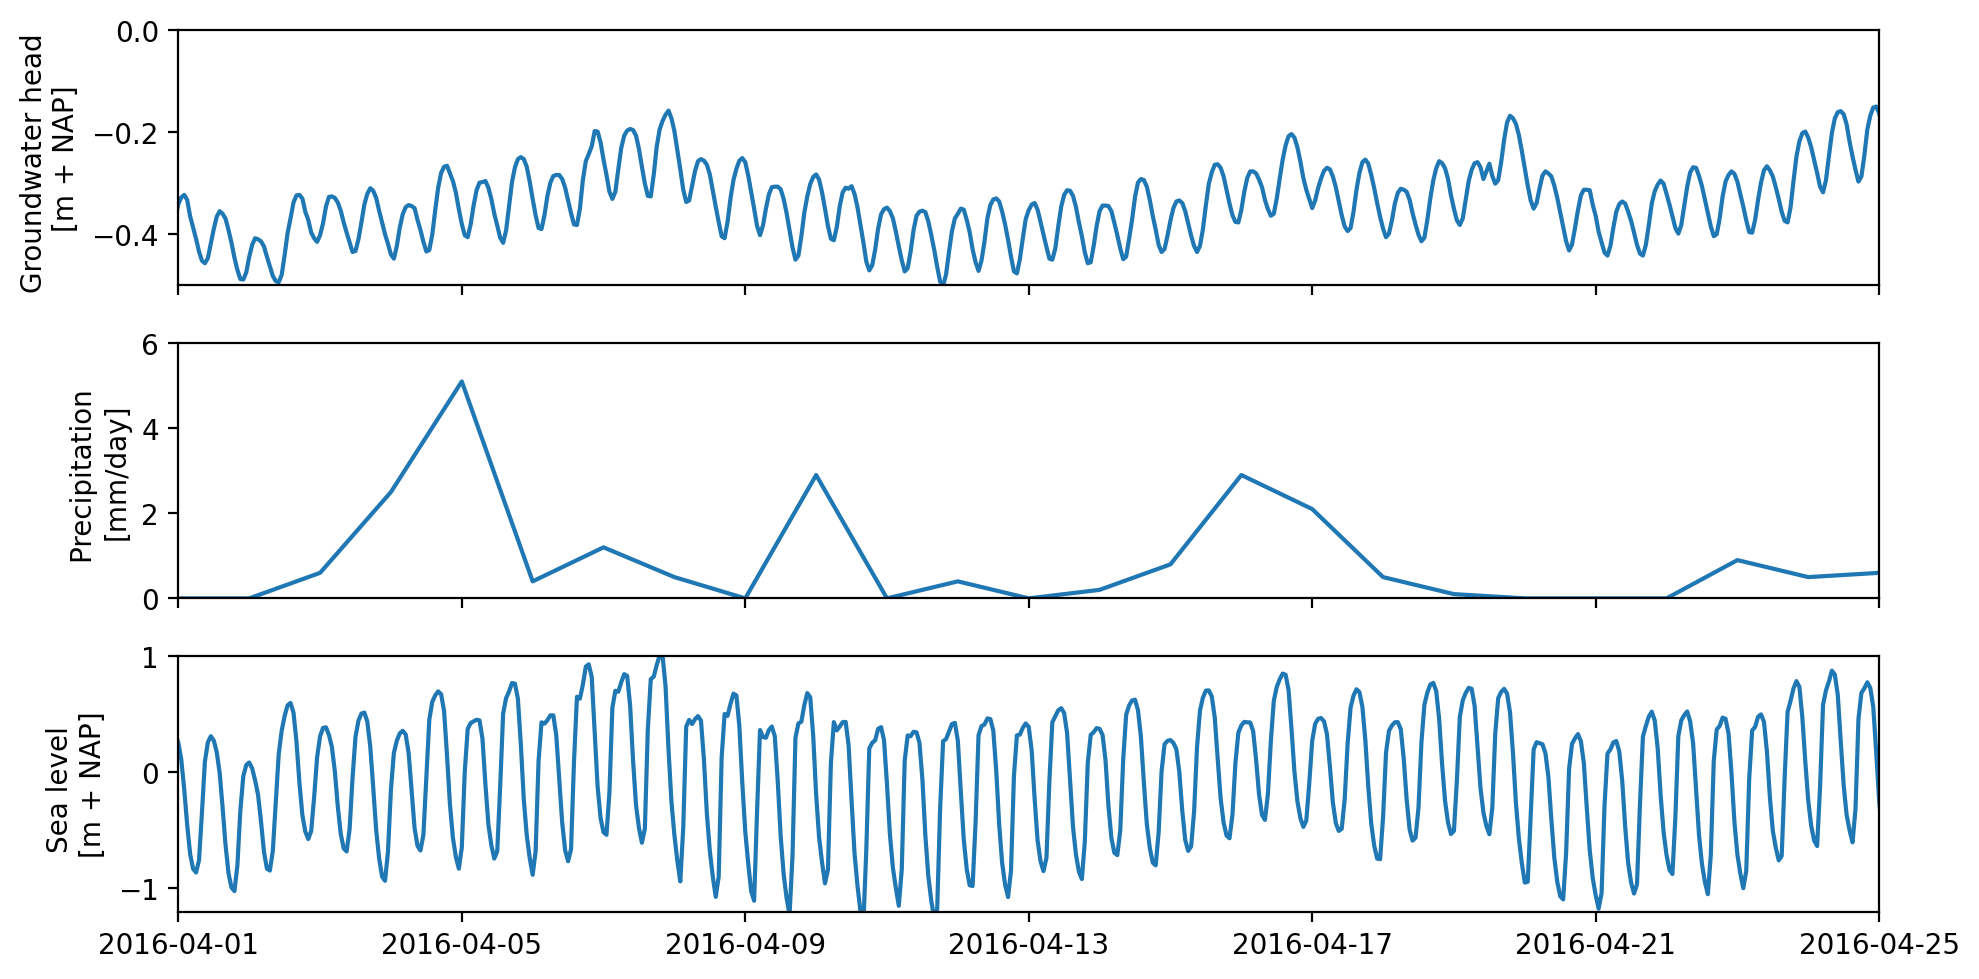

In [6]:
# Example where hourly data is better than daily

# Read groundwater head data, resample to hourly, and drop missing values
# head = pd.read_csv("data/PB_1_001_04P001442_F-2224.csv", index_col=0, parse_dates=True, squeeze=True).resample("H").mean().dropna()
head = pd.read_csv("data/PB_1_001_04P001442_F-2224.csv", index_col="index",
                   parse_dates=True).iloc[:, 0].resample("h").mean().dropna()

# Read explanatory series: precipitation, evaporation, and sea level
prec = pd.read_csv("data/RD Petten.csv", index_col=0, parse_dates=True)
evap = pd.read_csv("data/EV24 De Kooy.csv", index_col=0, parse_dates=True)
sea = pd.read_csv("data/Den Helder.csv", index_col=0, parse_dates=True)

# Plot including tidal influence
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

ax1.plot(head)
ax1.set_ylabel('Groundwater head \n[m + NAP]')

ax2.plot(prec * 1000)
ax2.set_ylabel('Precipitation \n[mm/day]')

ax3.plot(sea)
ax3.set_ylabel('Sea level \n[m + NAP]')

plt.xlim([np.datetime64("2016-04-01"), np.datetime64("2016-04-25")])
ax1.set_ylim([-0.5, 0])
ax2.set_ylim([0, 6])
ax3.set_ylim([-1.2, 1])

plt.tight_layout()

As a first attempt, we create a model with a time interval of one day. The figure below shows the result

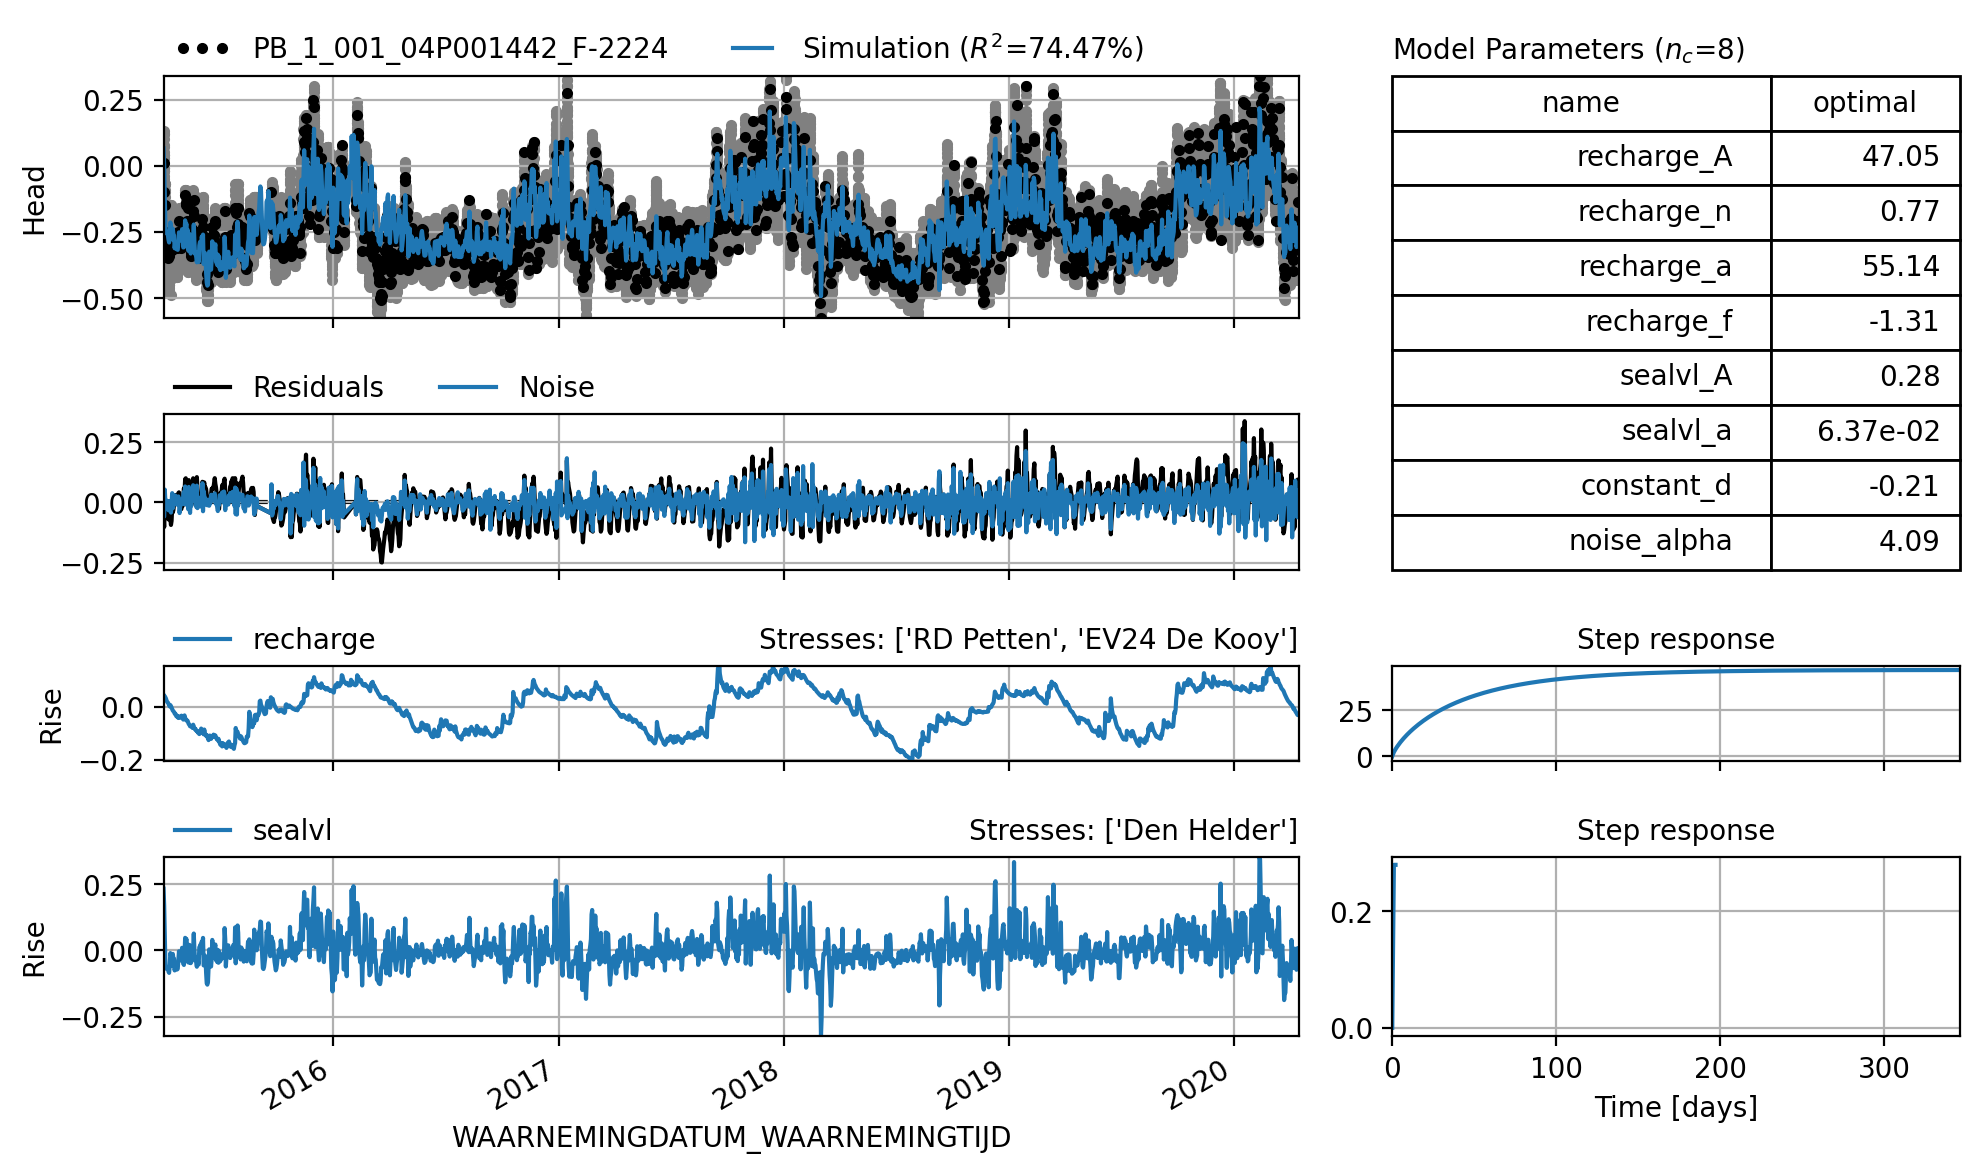

In [7]:
# dagelijks model gaat niet zo goed
ml = ps.Model(head, name="daily")
rm = ps.RechargeModel(prec, evap, name="recharge", rfunc=ps.Gamma())
ml.add_stressmodel(rm)
sm = ps.StressModel(sea - sea.mean(), ps.Exponential(), "sealvl",
                    settings="waterlevel")
ml.add_stressmodel(sm)
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(tmin="2015-04-01", report=False)
ml.plots.results(figsize=(10, 6), adjust_height=True)
plt.tight_layout();

It is clearly visible that the daily fluctuations are not being captured. A clear pattern can also be seen in the residuals. We will now try a simulation using hourly values.

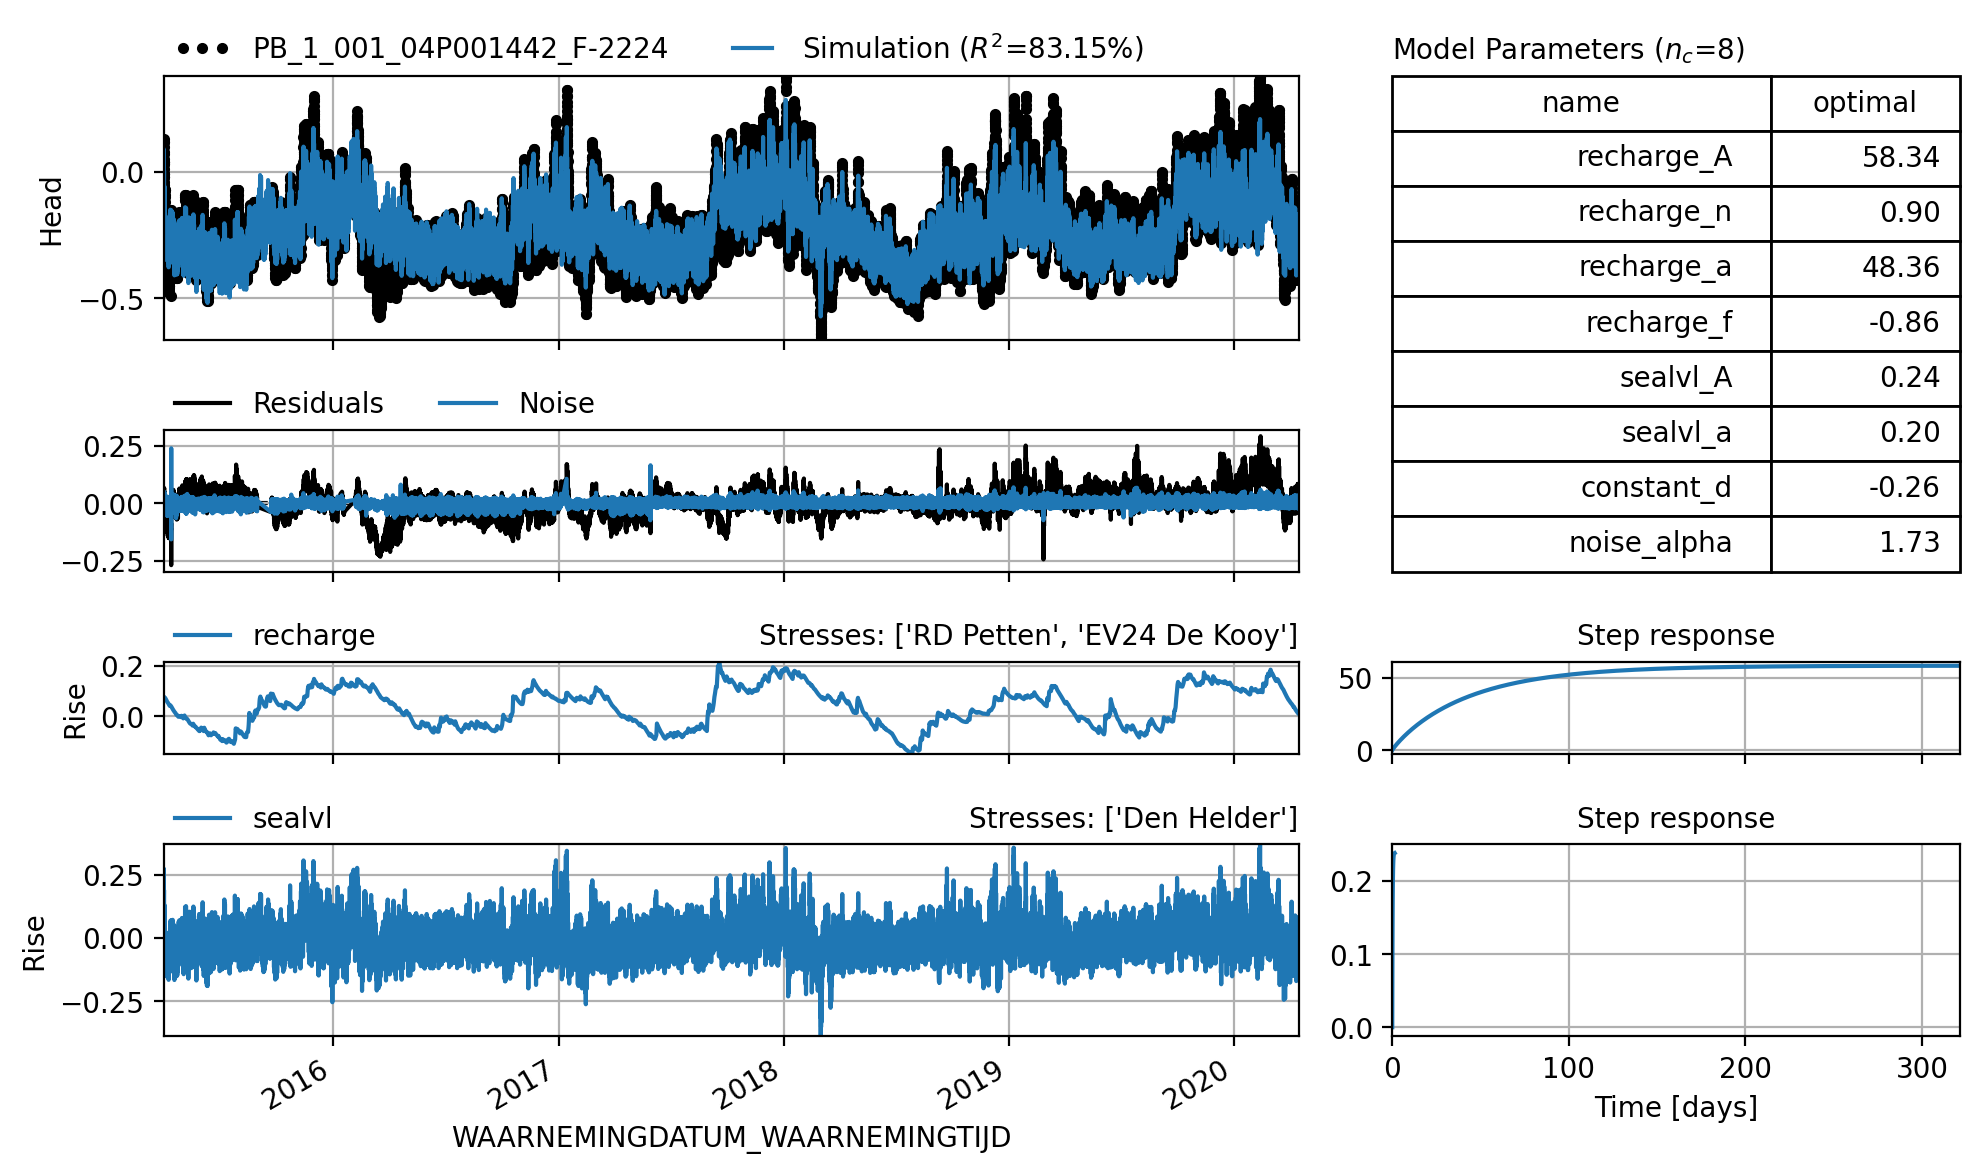

In [8]:
ml = ps.Model(head, name="hourly")
ml.settings["freq"] = "h"
rm = ps.RechargeModel(prec, evap, name="recharge", rfunc=ps.Gamma())
ml.add_stressmodel(rm)
sm = ps.StressModel(sea - sea.mean(), ps.Exponential(), "sealvl",
                    settings="waterlevel")
ml.add_stressmodel(sm)
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(tmin="2015-04-01", report=False)
ml.plots.results(figsize=(10, 6), adjust_height=True)
plt.tight_layout()

This model performs much better because the information present in the sea level can be used more effectively to explain the groundwater level.

## Making explanatory series equidistant

For most time series analysis programs, it is necessary that the explanatory series have equal time steps—that is, they must be equidistant. In some cases, they are already provided this way. If not, the series need to be made equidistant. 

How this is done depends on the type of explanatory series. River levels, for example, can be interpolated depending on the size of the time step and the dynamics of the series. For abstraction (extraction) series, one must consider whether a missing value means that the abstraction was turned off, or whether data is missing because no observation took place. 

Filling in data introduces uncertainties that are not automatically accounted for in the analysis. One may also choose to increase the time step of the time series analysis if that better matches the resolution of the available data. 

The figure below illustrates the different types of series:

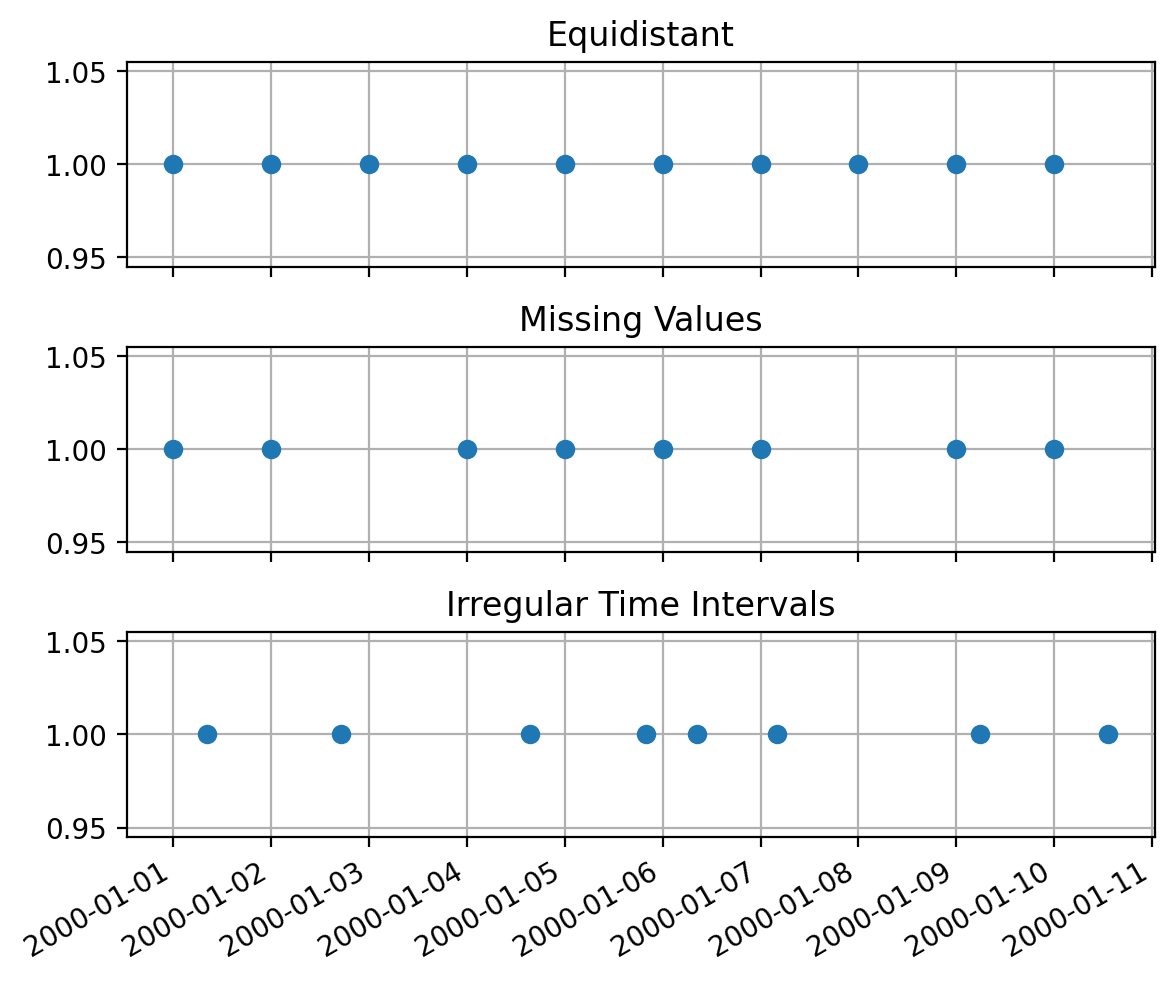

In [9]:
# Create a regular (equidistant) time series with daily frequency
regular = pd.Series(index=pd.date_range("2000-01-01", "2000-01-10", freq="D"),
                    data=np.ones(10))

# Create a copy and introduce missing values
missing_data = regular.copy()
missing_data.loc[["2000-01-03", "2000-01-08"]] = np.nan

# Create irregular time intervals by adding random offsets (in hours) to each timestamp
index = [t + pd.Timedelta(np.random.rand()*24, unit="h") for t in missing_data.index]
irregular = missing_data.copy()
irregular.index = index

# Plot the three series
fig, axes = plt.subplots(3, 1, figsize=(6, 5), sharex=True, sharey=True)

regular.plot(ax=axes[0], linestyle=" ", marker="o", x_compat=True)
missing_data.plot(ax=axes[1], linestyle=" ", marker="o", x_compat=True)
irregular.plot(ax=axes[2], linestyle=" ", marker="o", x_compat=True)

# Add titles and grid
for i, name in enumerate(["Equidistant", "Missing Values", "Irregular Time Intervals"]):
    axes[i].grid()
    axes[i].set_title(name)

plt.tight_layout()

## History of explanatory series

Every hydrological system has a certain memory. This means that the groundwater level depends on what happened during a preceding period. Therefore, each model has a certain warm-up period. 

When fitting a groundwater level time series, it is important that sufficient information on the explanatory series is available before the first observation used for calibration. If this is not the case, an estimate will have to be made, or the corresponding observations should be excluded from the optimization.

In the example below, precipitation is known for a period of 100 days before the first groundwater level measurement. Before that, it is assumed that precipitation was zero.

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.Columns (5,6,7,8,9,10,13,15,20,21,22,23,24,27,29,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.

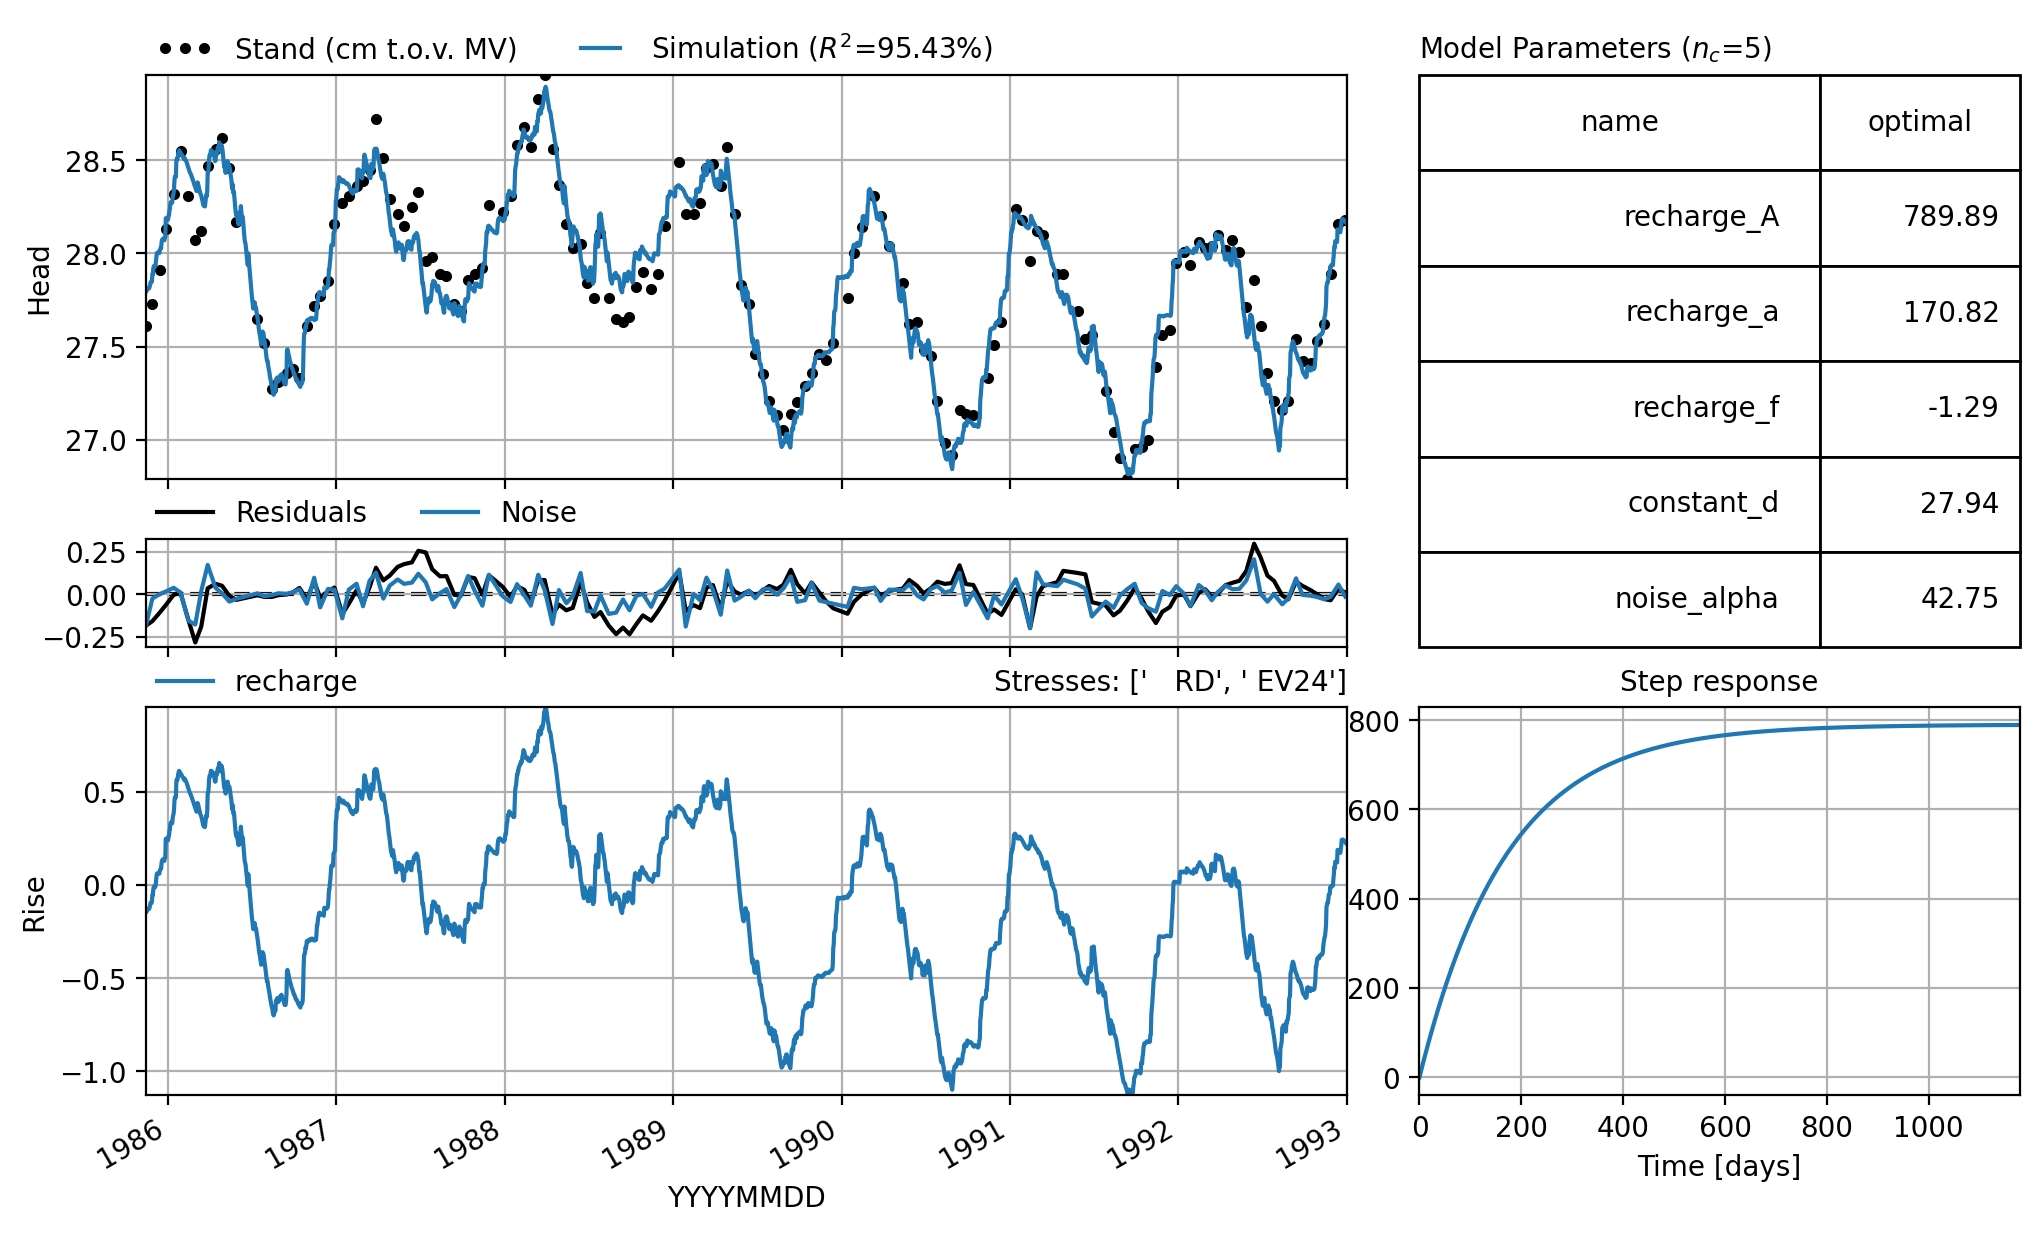

In [10]:
# Voorbeeld van warmup problematiek
obs = pd.read_csv('../calibration/data/B58C0698001_1.csv', skiprows=15, index_col=2, parse_dates=True).iloc[:, 4]/100

# lees weerdata


knmi = pd.read_csv('data/neerslaggeg_HEIBLOEM-L_967-2.txt', skiprows=23, index_col=0, parse_dates=True)
knmi.index = pd.to_datetime(knmi["YYYYMMDD"], format="%Y%m%d")
rain = knmi["   RD"].astype(float)/10000
evap = (
    pd.read_csv('../calibration/data/etmgeg_380.txt', skiprows=47, index_col=1, parse_dates=True)[' EV24']
    .replace('     ', np.nan)
    .astype(float) / 10000
)
'''
evap = ps.timeseries.TimeSeries(evap)
evap.settings["fill_before"] = 0.0

# also add 9 hours to the evaporation
s = evap.series_original
s.index = s.index + pd.to_timedelta(9, 'h')
evap.series_original = s
'''
# Create the time series model
ml = ps.Model(obs)

settingsprec = ps.timeseries.TimeSeries._predefined_settings['prec']
settingsprec['fill_before'] = 0.00
settingsevap = ps.timeseries.TimeSeries._predefined_settings['evap']

sm = ps.RechargeModel(
    prec=rain,
    evap=evap,
    rfunc=ps.Exponential(),
    name="recharge",
    settings=(settingsprec, settingsevap)  # Tuple of dicts is OK here
)
ml.add_stressmodel(sm)
ml.add_noisemodel(ps.ArNoiseModel())
# Solve
ml.solve(tmax='1993', report=False)
ml.plots.results(figsize=(10, 6));

It is clearly visible that the simulation lies below the measurements at the beginning of the series. This is compensated by an overestimation at the end of the series. In the example below, we use the same model, but now we assume average precipitation during the warm-up period.

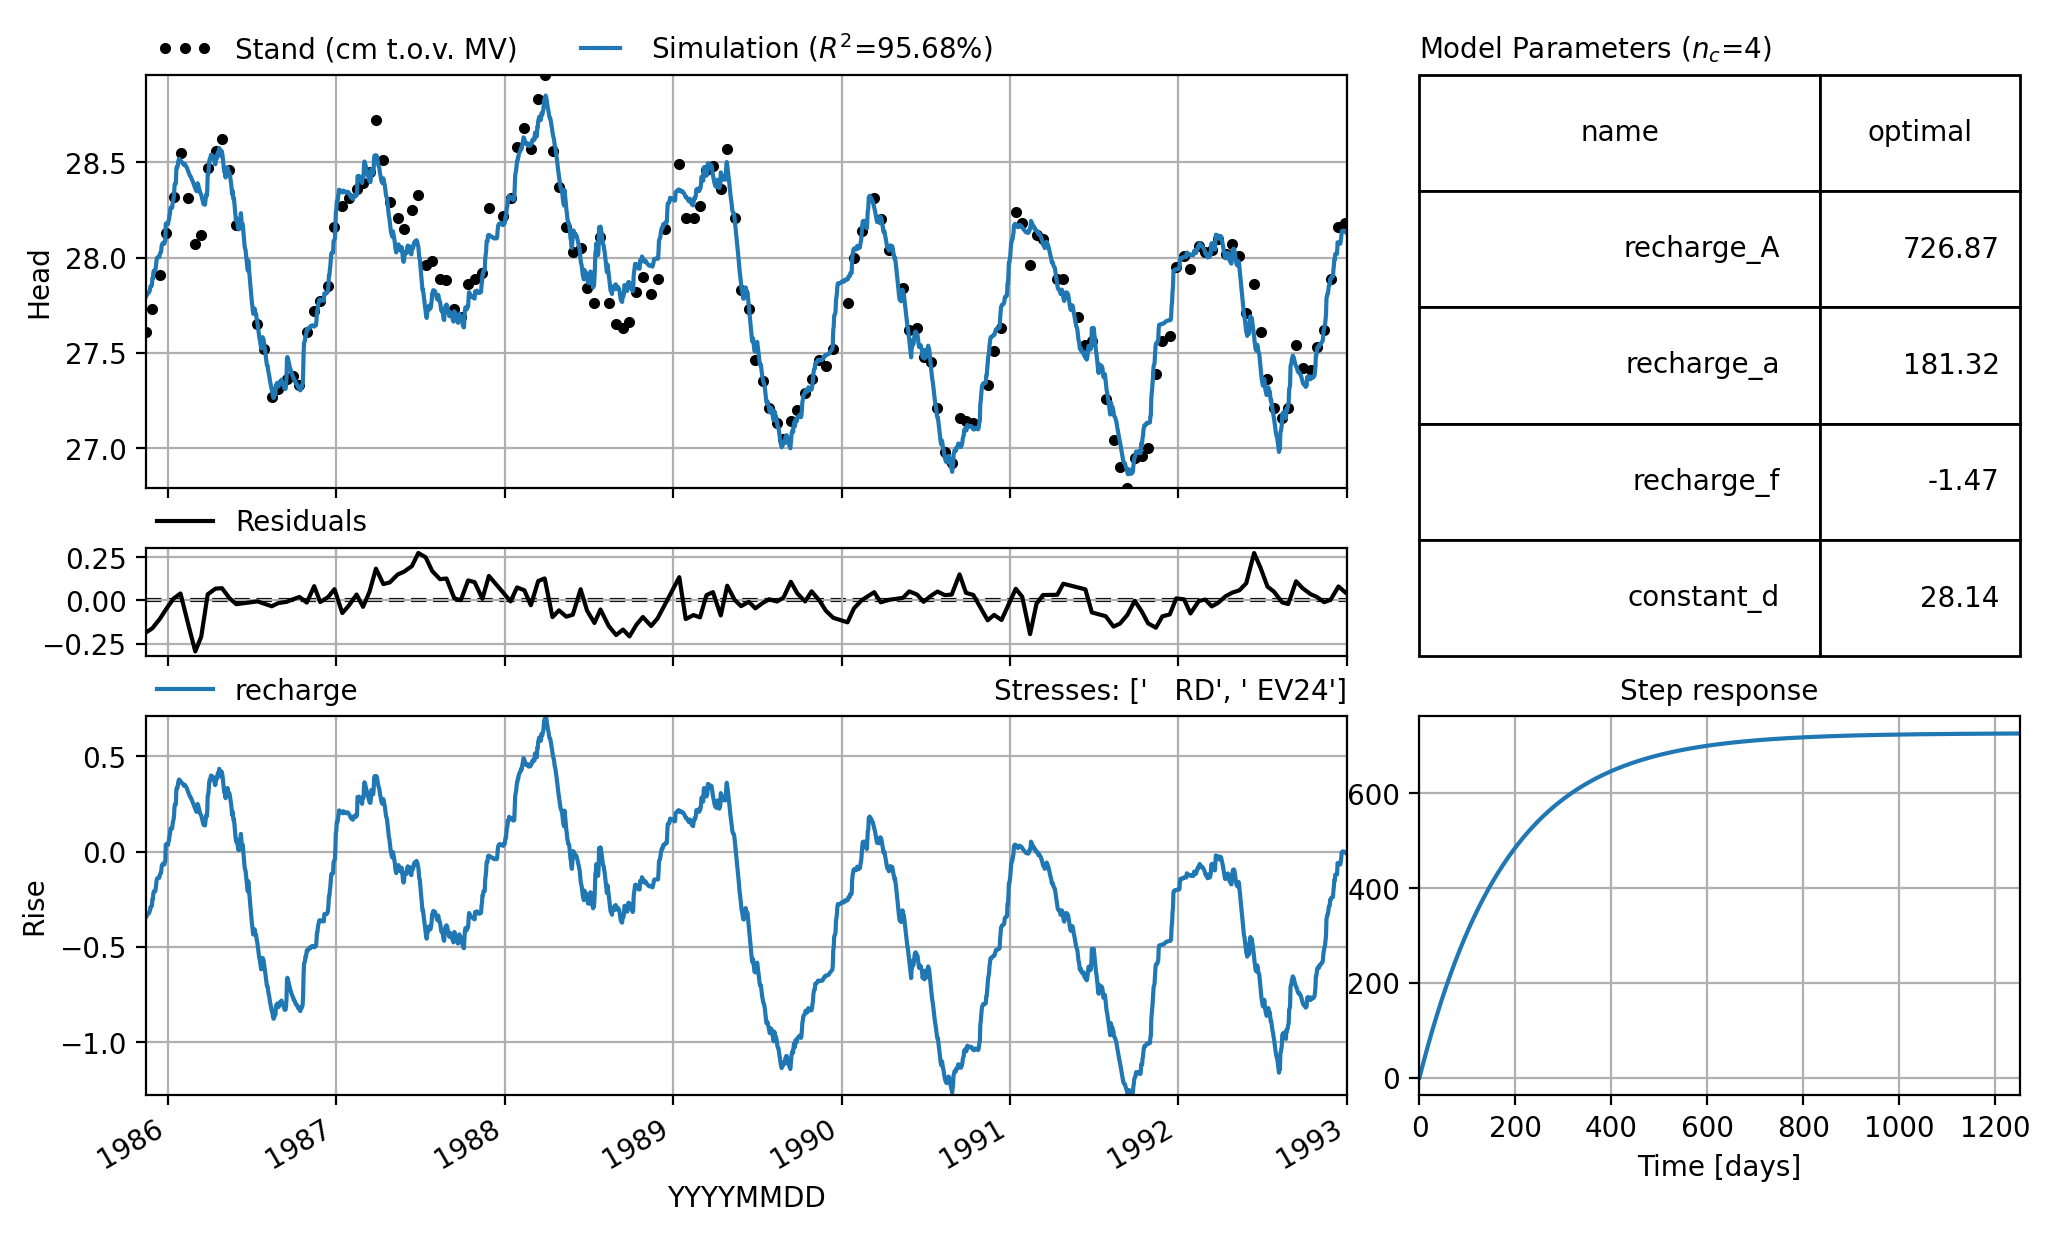

In [11]:
# Create the time series model
ml2 = ps.Model(obs)

settingsprec = ps.timeseries.TimeSeries._predefined_settings['prec']
settingsprec['fill_before'] = 'mean'
settingsevap = ps.timeseries.TimeSeries._predefined_settings['evap']

# Create stress
sm2 = ps.RechargeModel(
    prec=rain,
    evap=evap,
    rfunc=ps.Exponential(),
    name="recharge",
    settings=(settingsprec, settingsevap)  # Tuple of dicts is OK here
)
ml2.add_stressmodel(sm2)
ml.add_noisemodel(ps.ArNoiseModel())

# Solve
ml2.solve(tmax='1993', report=False)
ml2.plots.results(figsize=(10, 6));

Now that the average is taken before precipitation data is available, there is no longer a trend present in the residuals. The model fit has also improved, and the response to precipitation looks significantly different. The determined response time of the precipitation is much greater than 100 days. Therefore, it is important to have sufficient precipitation data, or a realistic estimate if such data is not available.

## Aligning Units

For the interpretation of results (and sometimes also for the success of the calibration), it is important to carefully choose and, if necessary, align the units of the different time series.

In the example below, we try to determine the influence of an abstraction. The input is provided on a daily basis in standard units. Precipitation and evaporation are given in meters per day, and the abstraction in cubic meters per day. 

We are interested in the total effect of the abstraction at the observation well. First, we perform a time series analysis using the units as they were provided:

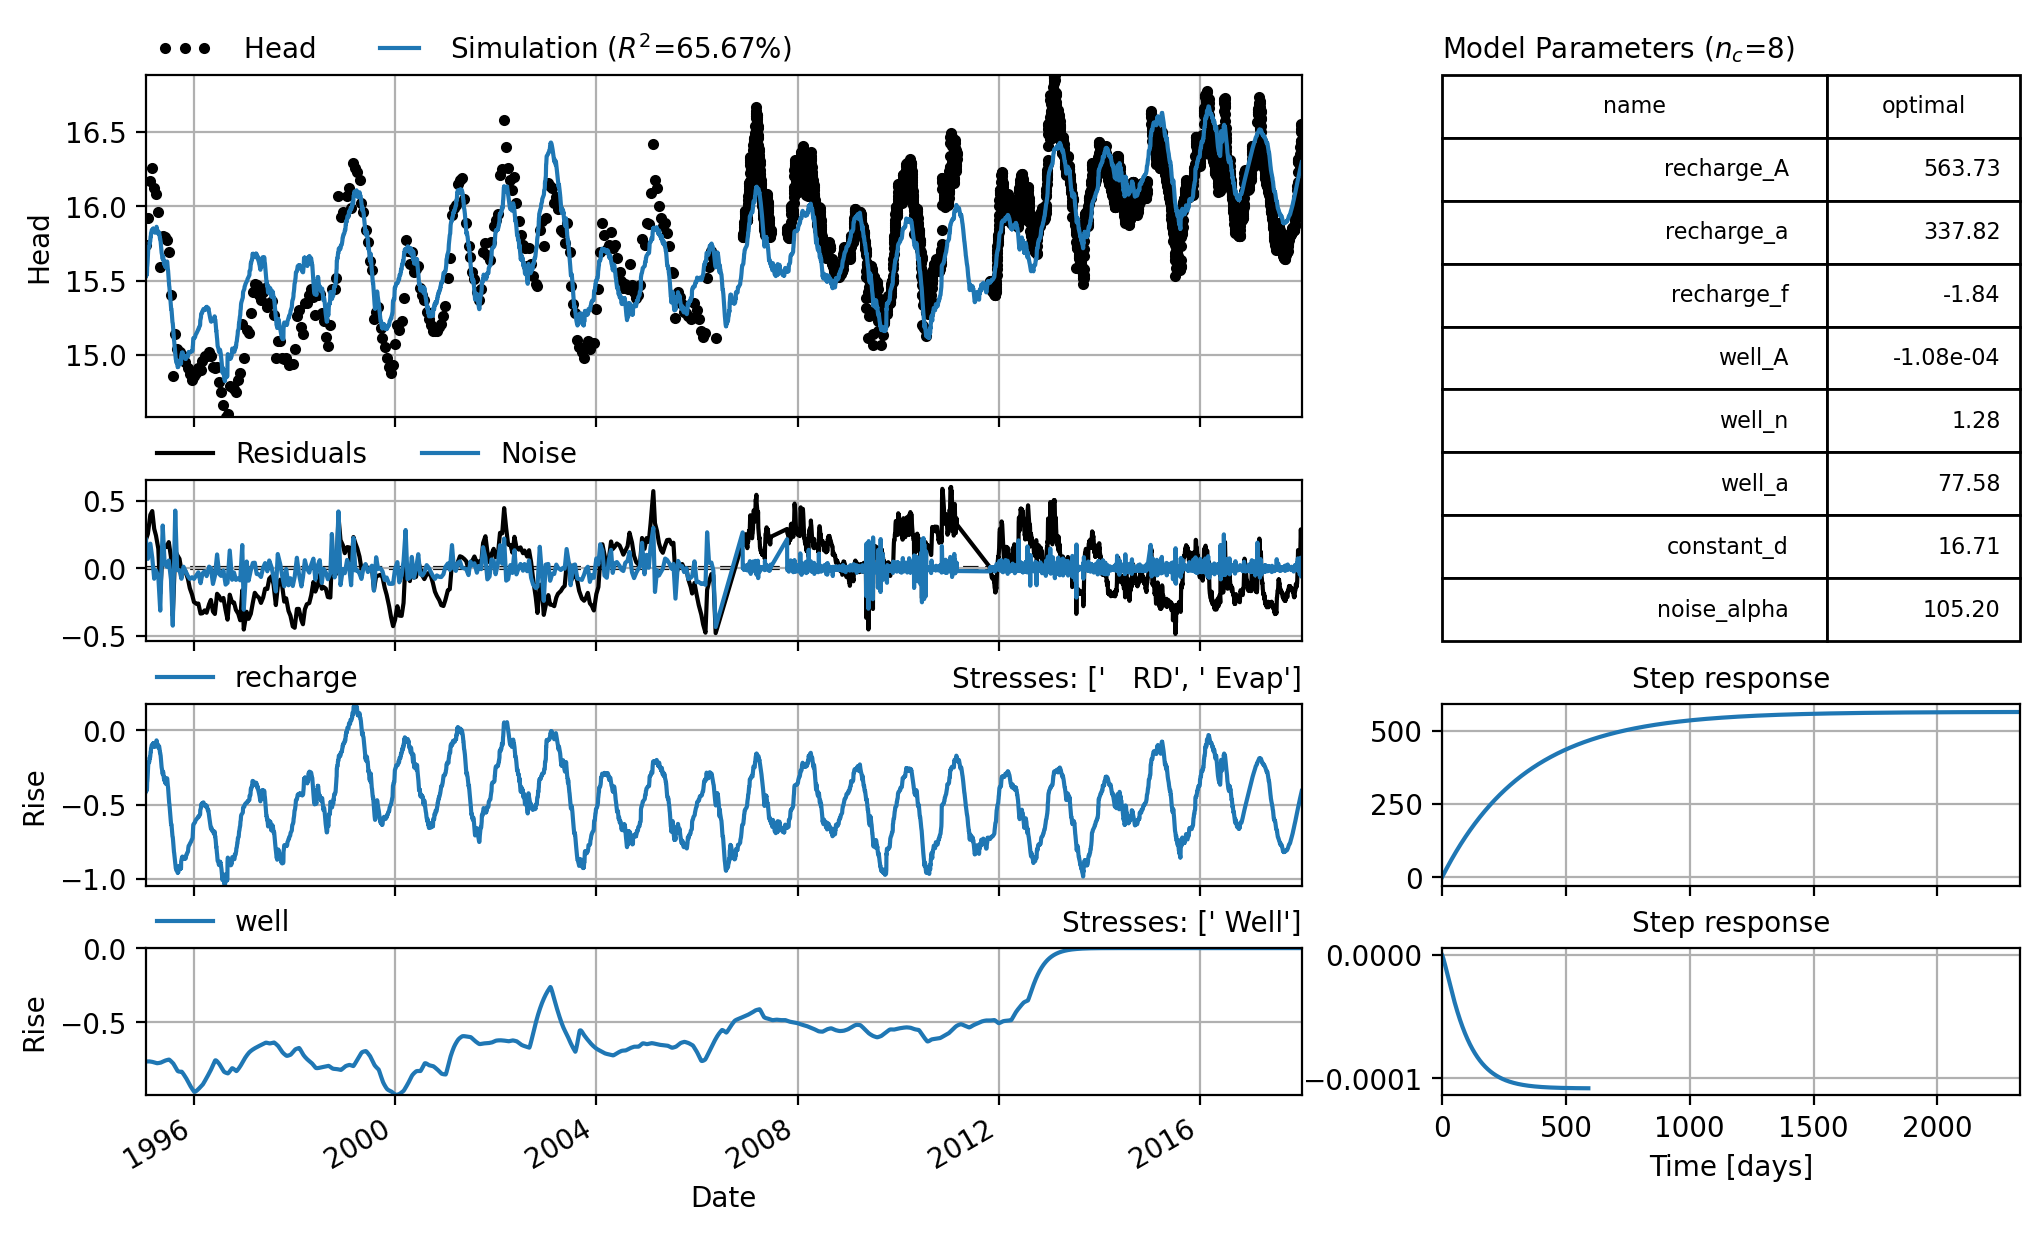

In [12]:
# Voorbeeld met verschillende eenheden, waardoor de gain niet te interpreteren is.
prec = pd.read_csv("data/prec_wellex.csv", index_col=0, parse_dates=True)
head = pd.read_csv("data/head_wellex.csv", index_col=0, parse_dates=True)
evap = pd.read_csv("data/evap_wellex.csv", index_col=0, parse_dates=True)
well = pd.read_csv("data/well_wellex.csv", index_col=0, parse_dates=True)

ml = ps.Model(head)
sm = ps.RechargeModel(rain, evap, name="recharge",
                      rfunc=ps.Exponential(), recharge=ps.rch.Linear())
ml.add_stressmodel(sm)
sm = ps.StressModel(well, rfunc=ps.Gamma(), name="well",
                    settings="well", up=False)
ml.add_stressmodel(sm)
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(initial=False, report=False, fit_constant='True')
ml.plots.results(figsize=(10, 6), adjust_height=True);

The effect of the well (the "gain") is equal to the parameter `well_A` in the table. This has the unit of head (groundwater level) divided by the unit of the abstraction. In this case, that means a reduction (in meters) for an abstraction of one cubic meter per day. 

The gain of the recharge represents the increase in groundwater level that would occur if it rained continuously at a rate of one meter per day (737 meters). Likewise, the reduction caused by one meter of evaporation per day is equal to 1.86 × 737 = 1370 meters.

These units are not very practical for interpretation. Therefore, we repeat the time series analysis, but this time we change the units of evaporation and precipitation to mm/day, and the abstraction to million cubic meters per year.

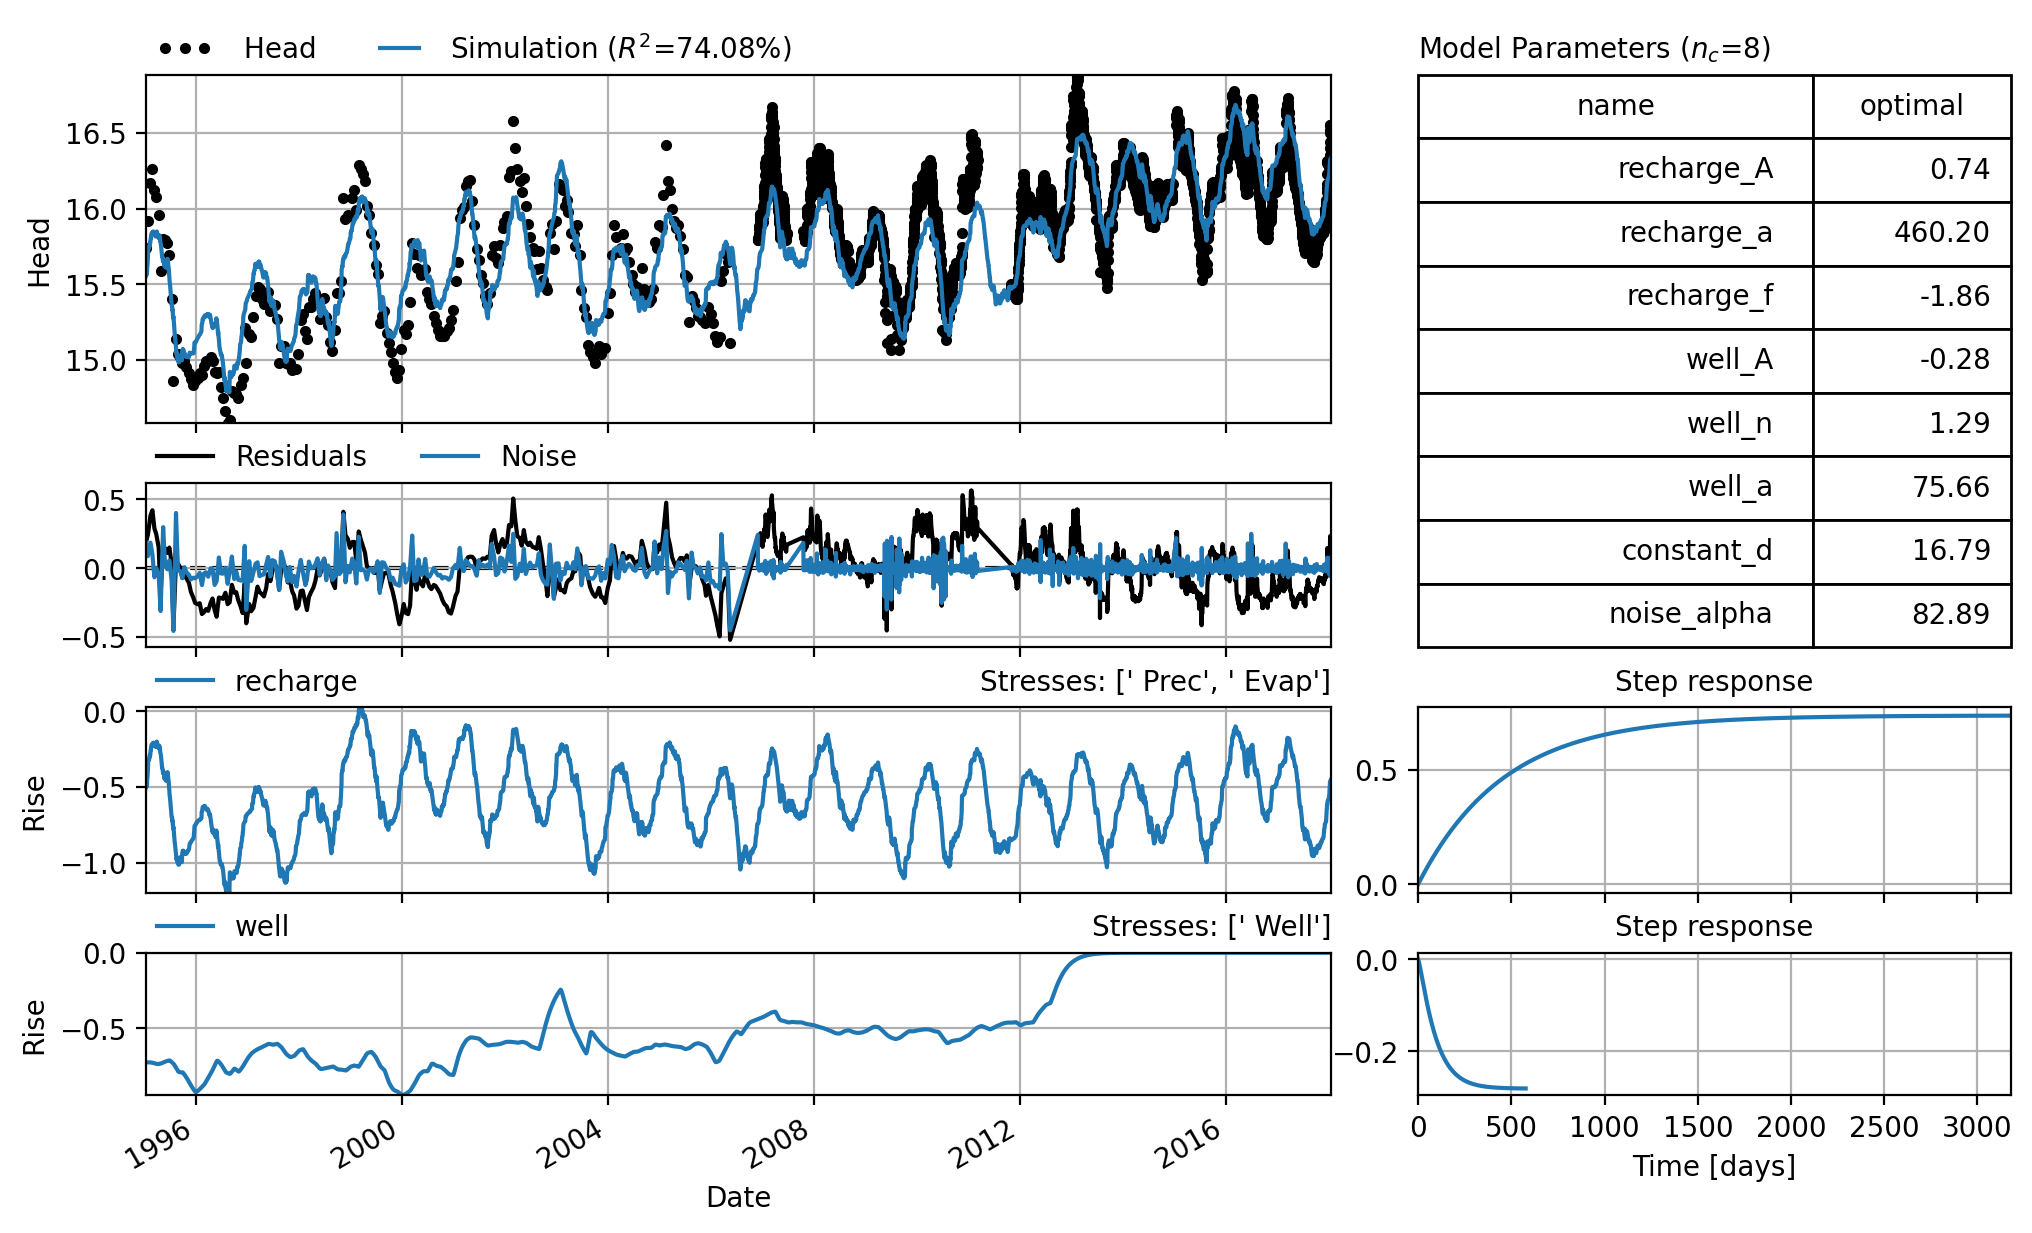

In [13]:
# Verandering naar een goed voorbeeld waar dat wel kan.
head = pd.read_csv("data/head_wellex.csv", index_col=0, parse_dates=True)
rain = pd.read_csv("data/prec_wellex.csv", index_col=0, parse_dates=True) * 1e3
evap = pd.read_csv("data/evap_wellex.csv", index_col=0, parse_dates=True) * 1e3
well = pd.read_csv("data/well_wellex.csv", index_col=0, parse_dates=True) * 365.25 / 1e6

ml = ps.Model(head)
sm = ps.RechargeModel(rain, evap, name="recharge",
                      rfunc=ps.Exponential(), recharge=ps.rch.Linear())
ml.add_stressmodel(sm)
sm = ps.StressModel(well, rfunc=ps.Gamma(), name="well",
                    settings="well", up=False)
ml.add_stressmodel(sm)
ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(initial=False, report=False, fit_constant='True')
ml.plots.results(figsize=(10, 6), adjust_height=True);

The figure above shows the results with the adjusted units. What stands out is that even after converting the units, the values differ slightly. These differences arise during the optimization of the parameters, which now proceeds slightly differently because the proportions between the input series have changed.

The gain from one millimeter of precipitation per day is now 0.76 meters. The reduction resulting from an abstraction of one million cubic meters per year is 0.74 meters. To estimate the final increase in groundwater level when the abstraction is stopped, this value must be multiplied by the actual abstraction capacity (in million cubic meters per year).

If the abstraction amounts to 2 million cubic meters per year, we estimate the resulting rise to be 148 centimeters.
